# data EDA

### install

In [1]:
# pip install pandas
# pip install seaborn
#pip install scikit-learn

### import


In [2]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(fname = 'NanumBarunGothic.ttf', name = 'NanumBarunGothic')

fm.fontManager.ttflist.insert(0, fe)
plt.rc('font', family='NanumBarunGothic')

import warnings
warnings.filterwarnings('ignore')

### data load

In [3]:
# test data
train = pd.read_csv('train.csv')

# label data load : 범죄발생구역 중에서 비슷한 범죄항목 비율이 있는 지역끼리 대구분을 해 보았음
label = pd.read_csv('label.csv')

# day data load : 요일을 월 ~ 일 까지 0~6으로 구분함
day = pd.read_csv('day.csv')

#train.head(3)
#label.head(5)

### 범죄발생지역 대구분 - 데이터 머지

In [4]:
f_data = pd.merge(left=train, right=label, left_on='범죄발생지', right_on='구역')
f_data.drop(columns=['구역', 'ID'], inplace=True)
f_data

,월,요일,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET,대구분
0,9,화요일,10,137,8.0,2.611124,0.000000,0.0,0.000000,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2,2311
1,11,화요일,6,438,13.0,3.209093,0.000000,0.0,0.000000,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0,2311
2,8,목요일,8,1846,36.0,2.321947,3.250000,0.0,0.000000,120.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,차도,1,2311
3,7,월요일,2,1747,46.0,1.453440,0.000000,0.0,0.000000,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2,2311
4,1,일요일,9,1347,36.0,1.631310,2.571429,1.5,4.333333,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2,2311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84401,7,수요일,5,1538,49.0,0.726402,0.000000,0.0,0.000000,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,공원,1,1230
84402,7,금요일,6,29,46.0,2.938977,0.000000,0.0,0.000000,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,공원,1,1230
84403,8,목요일,2,246,9.0,3.180908,3.250000,0.0,0.000000,120.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,공원,1,1230
84404,9,토요일,6,1627,43.0,0.394240,89.250000,0.0,0.000000,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,공원,1,1230


In [5]:
'''
여러개를 기준으로 머지 시킬때는 리스트 형태를 취한다.
마소 엑세스의 테이블끼리 조인해서 쿼리문을 만들때, 화살표와 같은 것!

 data = pd.merge(left=original, right=label, 
                left_on=['data', 'cadavercode'],
                right_on=['date', 'cadavercode']
                )
'''

"\n여러개를 기준으로 머지 시킬때는 리스트 형태를 취한다.\n마소 엑세스의 테이블끼리 조인해서 쿼리문을 만들때, 화살표와 같은 것!\n\n data = pd.merge(left=original, right=label, \n                left_on=['data', 'cadavercode'],\n                right_on=['date', 'cadavercode']\n                )\n"

### 요일 대구분 - 데이터 머지

In [6]:
f_data = pd.merge(left=train, right=day, left_on='요일', right_on='요일')

#f_data

In [7]:
# 중복 컬럼 데이터 드롭
f_data.drop(columns=['요일', 'ID'], inplace=True)

### 범주형 데이터 라벨링

In [8]:
f_data

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,범죄발생지,TARGET,day
0,9,10,137,8.0,2.611124,0.000000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,2,1
1,11,6,438,13.0,3.209093,0.000000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0,1
2,5,8,447,13.0,2.037493,4.125000,0.0,0.0,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주거지,0,1
3,6,12,1438,41.0,1.291232,2.428571,0.0,0.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0,1
4,2,6,1027,41.0,3.015956,0.000000,0.0,336.4,335.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,주거지,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84401,7,6,1328,30.0,1.430140,0.000000,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,인도,0,4
84402,8,4,2430,40.0,0.422111,14.000000,0.0,0.0,20.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,주거지,0,4
84403,6,3,739,19.0,2.439288,0.000000,0.0,0.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,차도,0,4
84404,5,9,2328,44.0,1.466624,0.000000,0.0,0.0,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,백화점,1,4


In [9]:
from sklearn.preprocessing import LabelEncoder

cat_feature = ['범죄발생지']

for i in cat_feature:
        
    le = LabelEncoder()

    # 범죄발생지를 LabelEncoder 의 fit_transform 에 넣어준다
    le.fit_transform(f_data[i].unique())

    new_cat = i+"_encorder"
    # 적용!
    f_data[new_cat] = le.transform(f_data[i])
    f_data.drop(columns=i, inplace=True)

In [10]:
f_data

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,TARGET,day,범죄발생지_encorder
0,9,10,137,8.0,2.611124,0.000000,0.0,0.0,245.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,10
1,11,6,438,13.0,3.209093,0.000000,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,10
2,5,8,447,13.0,2.037493,4.125000,0.0,0.0,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,7
3,6,12,1438,41.0,1.291232,2.428571,0.0,0.0,105.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,10
4,2,6,1027,41.0,3.015956,0.000000,0.0,336.4,335.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84401,7,6,1328,30.0,1.430140,0.000000,0.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,6
84402,8,4,2430,40.0,0.422111,14.000000,0.0,0.0,20.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,4,7
84403,6,3,739,19.0,2.439288,0.000000,0.0,0.0,250.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,10
84404,5,9,2328,44.0,1.466624,0.000000,0.0,0.0,220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,1


In [11]:
f_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84406 entries, 0 to 84405
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   월               84406 non-null  int64  
 1   시간              84406 non-null  int64  
 2   소관경찰서           84406 non-null  int64  
 3   소관지역            84406 non-null  float64
 4   사건발생거리          84406 non-null  float64
 5   강수량(mm)         84406 non-null  float64
 6   강설량(mm)         84406 non-null  float64
 7   적설량(cm)         84406 non-null  float64
 8   풍향              84406 non-null  float64
 9   안개              84406 non-null  float64
 10  짙은안개            84406 non-null  float64
 11  번개              84406 non-null  float64
 12  진눈깨비            84406 non-null  float64
 13  서리              84406 non-null  float64
 14  연기/연무           84406 non-null  float64
 15  눈날림             84406 non-null  float64
 16  TARGET          84406 non-null  int64  
 17  day             84406 non-null 

In [12]:
# 기술통계량을 확인하기위해 describe() 함수를 사용합니다.  
f_data.describe()

,월,시간,소관경찰서,소관지역,사건발생거리,강수량(mm),강설량(mm),적설량(cm),풍향,안개,짙은안개,번개,진눈깨비,서리,연기/연무,눈날림,TARGET,day,범죄발생지_encorder
count,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000,84406.000000
mean,6.430195,6.769507,1060.027581,26.881726,1.912424,24.608776,2.284407,23.430503,186.926107,0.385423,0.017842,0.144042,0.020330,0.010260,0.210755,0.008921,0.835355,3.091700,7.944862
std,3.108302,3.566390,698.380485,13.870968,0.958556,62.711211,15.852881,85.199896,98.299485,0.486698,0.132379,0.351134,0.141128,0.100771,0.407847,0.094030,0.819762,2.016831,2.261395
min,1.000000,1.000000,26.000000,5.000000,0.012269,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,4.000000,526.000000,13.000000,1.209985,0.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7.000000
50%,7.000000,7.000000,937.000000,27.000000,1.822279,0.625000,0.000000,0.000000,205.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000
75%,9.000000,10.000000,1638.000000,38.000000,2.476528,18.571429,0.000000,0.000000,260.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,5.000000,10.000000
max,12.000000,12.000000,2450.000000,54.000000,4.998936,614.875000,295.000000,649.800000,360.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,6.000000,13.000000


In [13]:
# 범죄발생지의 등장 빈도를 확인하는 코드입니다.  
train['범죄발생지'].value_counts()

범죄발생지
주거지      36077
차도       25879
인도        6437
편의점       4835
주차장       3262
식당        1806
백화점       1493
주유소       1324
공원         736
학교         728
약국         653
호텔/모텔      591
병원         453
은행         132
Name: count, dtype: int64

### visualization

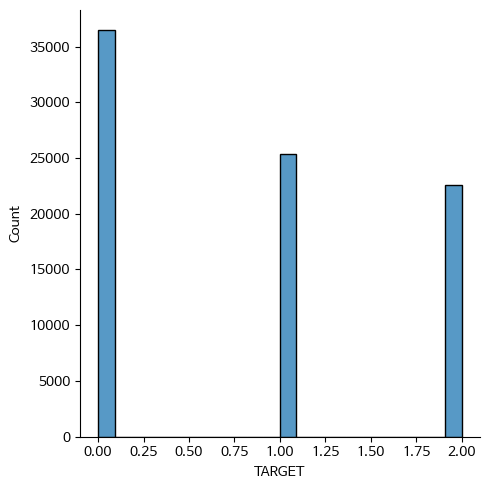

In [14]:
# 종속변수 분포 확인
sns.displot(f_data['TARGET'])

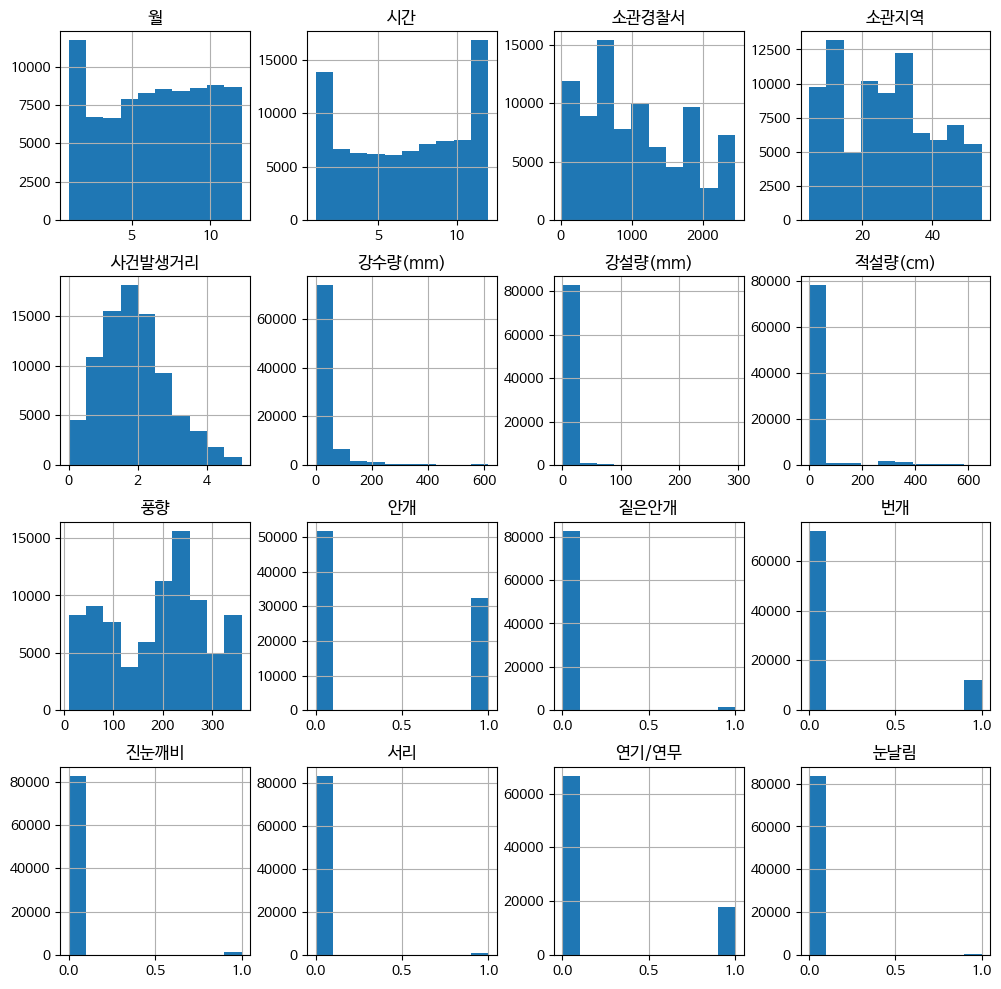

In [15]:
# 전체 데이터 분포 확인
except_target = train.drop('TARGET', axis = 1)
except_target.hist(figsize = (12,12))
plt.show()

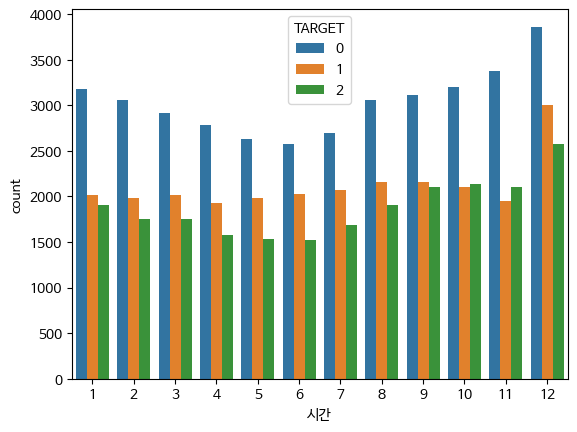

In [16]:
# 시간대별 발생 범죄 빈도 확인
sns.countplot(x = '시간', hue = 'TARGET', data = f_data)
plt.show()

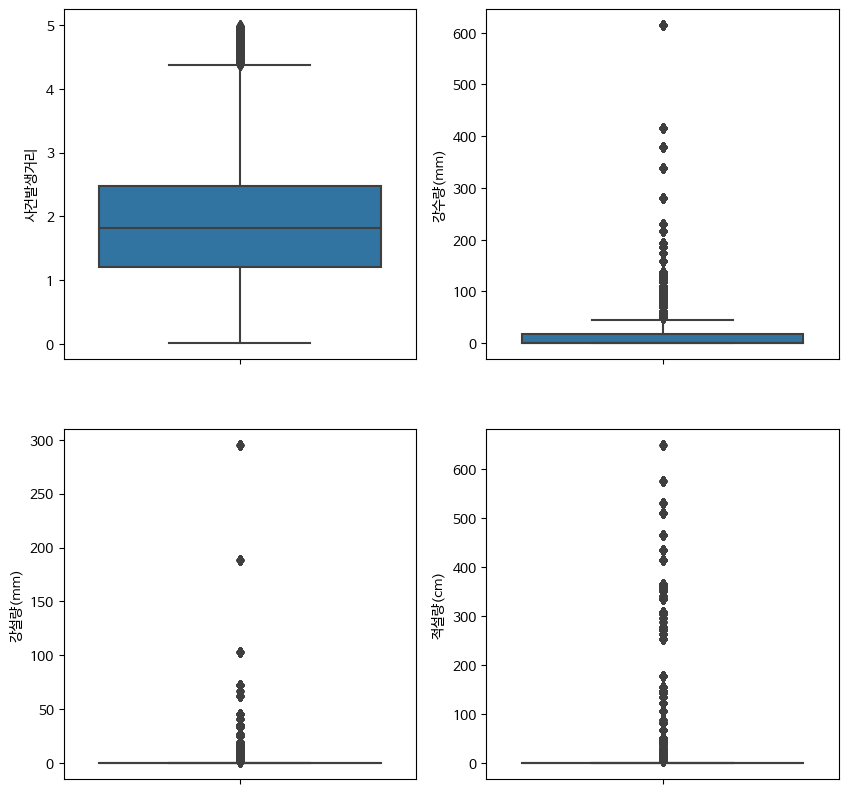

In [17]:
# 이상치 확인
fig, axes = plt.subplots(2,2, figsize = (10,10))

sns.boxplot(y = train['사건발생거리'], ax = axes[0][0])
sns.boxplot(y = train['강수량(mm)'], ax = axes[0][1])

sns.boxplot(y = train['강설량(mm)'], ax = axes[1][0])
sns.boxplot(y = train['적설량(cm)'], ax = axes[1][1])

plt.show()

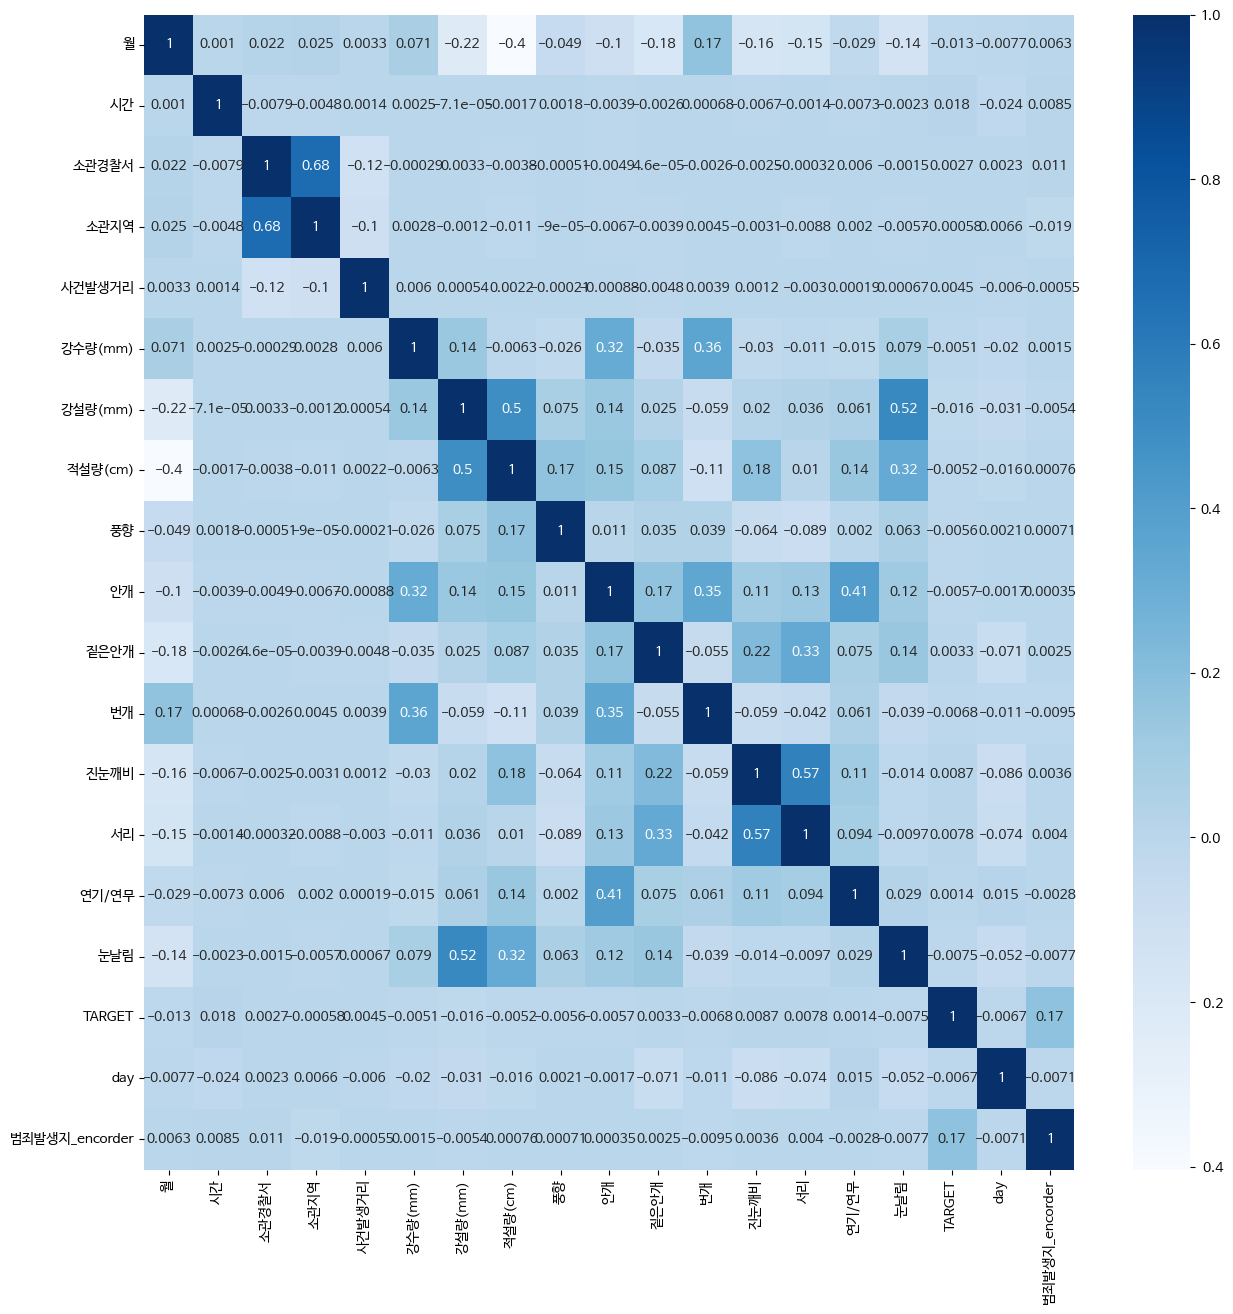

In [18]:
# 상관관계 확인
plt.figure(figsize = (15,15), dpi = 100)
sns.heatmap(f_data.corr(), annot = True, cmap = 'Blues')
plt.show()